In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

In [ ]:
aksiom = 'FL'
rools = {'F':'', 
        'L': 'FL-FR--FR+FL++FLFL+FR-', 
         'R': '+FL-FRFR--FR-FL++FL+FR'}
interpretation = {'F': 'forward 1', 
                  '+': 'rotate 60', 
                  '-': 'rotate -60'}

In [ ]:
def scale(x1, y1, x2, y2, length):
  length_ = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
 
  scale = length / length_
  scale_matrix = np.array([[scale, 0], 
                           [0, scale]])
  center_point = np.array([x2 - x1, y2 - y1])
  point = np.array([x1, y1]) + center_point @ scale_matrix 
  return x1, y1, int(np.rint(point[0])), int(np.rint(point[1]))

def rotate(x1, y1, x2, y2, angle):
  radian_angle = np.deg2rad(angle)
  rotate_matrix = np.array([[np.cos(radian_angle), - np.sin(radian_angle)], 
                            [np.sin(radian_angle), np.cos(radian_angle)]])
  center_point = np.array([x2 - x1, y2 - y1])
  point = np.array([x1, y1]) + center_point @ rotate_matrix
  return x1, y1, int(np.rint(point[0])), int(np.rint(point[1]))
  
def rotate_scale(x1, y1, x2, y2, length, angle):
  x1, y1, x2, y2 = rotate(x1, y1, x2, y2, angle)
  return scale(x1, y1, x2, y2, length)  


In [ ]:
def create_generations(start, rools, generation_cnt):
  replacement = dict((re.escape(k), v) for k, v in rools.items()) 
  pattern = re.compile("|".join(replacement.keys()))
  for i in range(generation_cnt):
    start = pattern.sub(lambda m: replacement[re.escape(m.group(0))], start)
  return start

def create_generations_n(start, rools, interpretation, generation_cnt):
  for i in range(generation_cnt):
    current_rools = rools.copy()
    for k, v in current_rools.items():
      replt = dict((re.escape(k), k + '_' + str(i)) for k in interpretation.keys())
      pattern = re.compile('|'.join(replt.keys()))
      current_rools[k] = pattern.sub(lambda m: replt[re.escape(m.group(0))], v)
  replacement = dict((re.escape(k), v) for k, v in current_rools.items()) 
  pattern = re.compile("|".join(replacement.keys()))
  for i in range(generation_cnt):
    start = pattern.sub(lambda m: replacement[re.escape(m.group(0))], start)
  return start



In [ ]:
create_generations(aksiom, rools,  2)

'FL-FR--FR+FL++FLFL+FR--+FL-FRFR--FR-FL++FL+FR--+FL-FRFR--FR-FL++FL+FR+FL-FR--FR+FL++FLFL+FR-++FL-FR--FR+FL++FLFL+FR-FL-FR--FR+FL++FLFL+FR-++FL-FRFR--FR-FL++FL+FR-'

Деревья


In [ ]:
aksiom = 'X'
rools = {
  'X': 'F[@[-X]+X]'
}
interpretation = {
    'F':'forward 1',
    'X':'forward 1',
    '+':'rotate random 45', 
    '-':'rotate -random 45', 
    '[': 'save', 
    ']': 'restore',
    '@': 'beatify'
}

In [ ]:
def parse_command(comm):
  command_parts = interpretation[comm].split(' ')
  random = ''
  if len(command_parts) == 3:
    command, random, value = command_parts[0], command_parts[1], int(command_parts[2])
    if random[0] == '-':
      value = -value
  if len(command_parts) == 2:
    command, value = command_parts[0], int(command_parts[1])
  if len(command_parts) == 1:
    command = command_parts[0]
  value = int(value)
  return command, random, value 

def update_color(initial_color, ended_color, generation_cnt, n):
  initial_weight, ended_weight = n / generation_cnt, (generation_cnt - n) / generation_cnt
  return initial_weight * initial_color + ended_weight * ended_color

def update_thickness(generation_cnt, n):
  return generation_cnt - n + 1


def create_enterpretation(program, interpretation, params, start_x=0, start_y=0):
  color = params['initial_color']
  thickness = params['thickness']
  length = params['length']

  x1, y1 = start_x, start_y
  x2, y2 = start_x + length, start_y
  stack = []
  points = []
  
  for op in program:
    if op not in interpretation: continue
    command, random, value = parse_command(interpretation[op])
   
    if command == 'forward':
      x1, y1, x2, y2 = scale(x1, y1, x2, y2, length * value)
      if 0 <= x1 <= width and 0 <= x2 <= width and 0 <= y1 <= height and 0 <= y2 <= height:
        points.append(([x1, y1, x2, y2], color, thickness))
        delta_x, delta_y = x2 - x1, y2 - y1
        x1, y1 = x2, y2
        x2, y2 = x2 + delta_x, y2 + delta_y
    elif command == 'rotate':
      x1, y1, x2, y2 = rotate(x1, y1, x2, y2, value)
    elif command == 'save':
      stack.append([x1, y1, x2, y2])
    elif command == 'restore':
      x1, y1, x2, y2 = stack[-1]
      stack.pop(-1)
    elif command == 'beatify':
      thickness = update_thickness()
      color = update_color()      
    return points

def draw_points(points, widht=1200, height=900):
  canvas = np.ones((height, width, 3)) * 255
  for line in points:
    coords, color, thickness = line
    canvas = cv2.line(canvas, (), (), color, thickness)
  return canvas 


def rescale_points(points, width, height):
  points_coords = np.array(list(map(lambda line: line[0], points)))
  min_x = min(np.min(points_coords[:, 0]), np.min(points_coords[:, 2])) 
  min_y = min(np.min(points_coords[:, 1]), np.min(points_coords[:, 3]))
  max_x = max(np.max(points_coords[:, 0]), np.max(points_coords[:, 2]))
  max_y = max(np.max(points_coords[:, 1] ), np.max(points_coords[:, 3]))
  width_ = max_x - min_ + 100
  height_ = max_y - min_y + 100
  ratio_x  = width_ / width
  ratio_y = height_ / height_
  for i in range(len(points)):
    x1, y1, x2, y2 = points[i][0]
    x1 , x2 = x1 * ratio_x, x2 * ratio_x
    y1, y2 = y1 * ratio_y, y2 * ratio_y
    points[i][0][0] = x1
    points[i][0][1] = y1
    points[i][0][2] = x2
    points[i][0][3] = y2 
  return points





In [ ]:


def draw_interpretation(program, interpretation, width=1200, height=900, start_x=500, start_y=500, length=50):
  canvas = np.ones((height, width, 3)) * 255
  x1, y1 = start_x, start_y
  x2, y2 = start_x + length, start_y
  for op in program.split('^'):
    if len(op) < 2: continue
    op, generation = op[0], op[1]
    if op not in interpretation: continue
    
    command, value = interpretation[op].split(' ')
    value = int(value)
    if command == 'forward':
      x1, y1, x2, y2 = scale(x1, y1, x2, y2, length * value)
      if 0 <= x1 <= width and 0 <= x2 <= width and 0 <= y1 <= height and 0 <= y2 <= height:
        canvas= cv2.line(canvas, (x1, y1), (x2, y2), (0,0,0), 3)
        delta_x, delta_y = x2 - x1, y2 - y1
        x1, y1 = x2, y2
        x2, y2 = x2 + delta_x, y2 + delta_y
    elif command == 'rotate':
      x1, y1, x2, y2 = rotate(x1, y1, x2, y2, value)

  return canvas

In [ ]:
program = create_generations(aksiom, rools, interpretation,  5)
image = draw_interpretation(program, interpretation, start_x=500, start_y=200, length=10)

In [ ]:
program

'^0^^1^^2^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^-3^^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^-3^^-3^^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^+3^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^+3^^+3^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^+3^^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^-3^^-2^^2^^+3^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^-3^^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^-3^^-3^^3^^+4^^F4^L^-4^^F4^R^F4^R^-4^^-4^^F4^R^-4^^F4^L^+4^^+4^^F4^L^+4^^F4^R^-3^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^+3^^+3^^3^^F4^L^-4^^F4^R^-4^^-4^^F4^R^+4^^F4^L^+4^^+4^^F4^L^F4^L^+4^^F4^R^-4^^+3^^3^^+4^^F

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


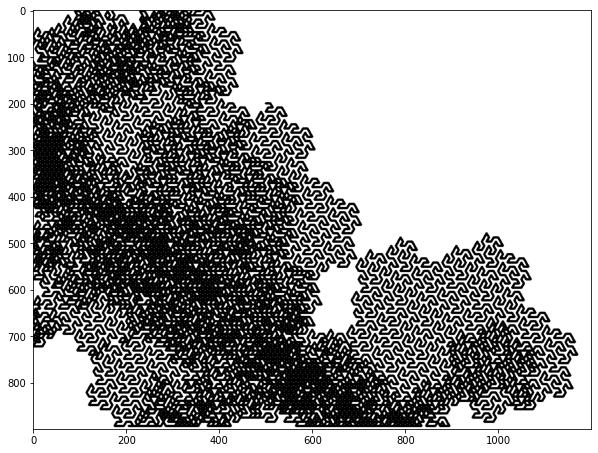

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)